# Instantiation

In [31]:
using Pkg
Pkg.activate("..") #Activate the project environment
#Pkg.instantiate() #Install the required packages    
# Load the required packages
using ModelingToolkit, DifferentialEquations, Plots,PhysicsInformedRegression, Catalyst

  Activating project at `c:\Users\Marcu\OneDrive - Danmarks Tekniske Universitet\DTU\Physics-Informed-Regression`


# Enzyme dynamics
The underlying reaction network for Michaelis-Menten kinetics is defined as follows:


In [32]:
# Define the reaction network
model = @reaction_network begin
    k_a, E + S --> ES
    k_d, ES --> S + E
    k_c, ES --> E + P
end
model

Model ##ReactionSystem#322:
Unknowns (4): see unknowns(##ReactionSystem#322)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#322)
  k_a
  k_d
  k_c

Which converts to the following ODE system:


In [33]:
# Generate ODEs from the reaction network
sys = convert(ODESystem, model)
sys = structural_simplify(sys)

Model ##ReactionSystem#322:
Equations (4):
  4 standard: see equations(##ReactionSystem#322)
Unknowns (4): see unknowns(##ReactionSystem#322)
  E(t)
  ES(t)
  P(t)
  S(t)
Parameters (3): see parameters(##ReactionSystem#322)
  k_c
  k_d
  k_a

# Simulation of the Enzyme Dynamics
The system of ODEs is solved using the `DifferentialEquations.jl` package in Julia and the `Tsit5()` solver. The initial conditions are set to
$$
\begin{align*}
E_0 &= 1 \\
S_0 &= 1 \\
ES_0 &= 0 \\
P_0 &= 0 \\
\end{align*}
$$
with the parameters:
$$
\begin{align*}
k_a &= 0.3 \\
k_d &= 0.2 \\
k_c &= 0.1 \\
\end{align*}
$$

The simulation runs for 10 seconds with a time step of 0.2 seconds

In [34]:
# simulate the ODEs
@parameters k_a, k_d, k_c
u₀ = [1.0, 1.0, 0.0, 0.0]
tspan = (0.0, 10.0)
p = Dict(
    k_a => 0.3,
    k_d => 0.2,
    k_c => 0.1
)

prob = ODEProblem(sys, u₀, tspan, p)
sol = solve(prob, Tsit5(), saveat=0.2)

retcode: Success
Interpolation: 1st order linear
t: 51-element Vector{Float64}:
  0.0
  0.2
  0.4
  0.6
  0.8
  1.0
  1.2
  1.4
  1.6
  1.8
  ⋮
  8.4
  8.6
  8.8
  9.0
  9.2
  9.4
  9.6
  9.8
 10.0
u: 51-element Vector{Vector{Float64}}:
 [1.0, 1.0, 0.0, 0.0]
 [1.057062260621103, 0.9429377393788971, 0.019419691180669336, 0.037642569440433676]
 [1.108513035866826, 0.8914869641331741, 0.03775493220611458, 0.0707581036607113]
 [1.1547723588942316, 0.8452276411057685, 0.05511378332262284, 0.09965857557160859]
 [1.1962772440368412, 0.8037227559631588, 0.07159575044207205, 0.1246814935947692]
 [1.2334656597070828, 0.7665343402929173, 0.08729147513928061, 0.14617418456780207]
 [1.2667649887579435, 0.7332350112420564, 0.10228306399125085, 0.16448192476669277]
 [1.296583101012537, 0.703416898987463, 0.11664414932968611, 0.17993895168285104]
 [1.3233011289221017, 0.6766988710778983, 0.13044037481362705, 0.19286075410847472]
 [1.3472741465741005, 0.6527258534258996, 0.14373040384802166, 0.20354374

# Physics-informed regression
The [PhysicsInformedRegression](https://github.com/MarcusGalea/PhysicsInformedRegression.jl) package is used to solve the inverse problem of the SIR model. The system is rewritten as a linear system of equations, and the parameters $\beta$ and $\gamma$ are estimated using the observations. The following code snippet shows how to set up and solve the inverse problem:


In [35]:
# Setup model for regression
using Latexify
using LaTeXStrings
using PhysicsInformedRegression

A,b = PhysicsInformedRegression.setup_linear_system(sys)
A_sym = latexify(A; inline = true)
b_sym = latexify(b; inline = true)
display(A_sym)
display(b_sym)

L"\begin{equation}
\left[
\begin{array}{ccc}
\mathrm{\mathtt{ES}}\left( t \right) & \mathrm{\mathtt{ES}}\left( t \right) &  - E\left( t \right) S\left( t \right) \\
 - \mathrm{\mathtt{ES}}\left( t \right) &  - \mathrm{\mathtt{ES}}\left( t \right) & E\left( t \right) S\left( t \right) \\
\mathrm{\mathtt{ES}}\left( t \right) & 0.0 & 0.0 \\
0.0 & \mathrm{\mathtt{ES}}\left( t \right) &  - E\left( t \right) S\left( t \right) \\
\end{array}
\right]
\end{equation}
"

L"\begin{equation}
\left[
\begin{array}{c}
\frac{\mathrm{d} E\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} \mathrm{\mathtt{ES}}\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} P\left( t \right)}{\mathrm{d}t} \\
\frac{\mathrm{d} S\left( t \right)}{\mathrm{d}t} \\
\end{array}
\right]
\end{equation}
"

The enzymatic reaction model can be represented as a linear system of equations:
$$
\begin{align*}
    \left[
    \begin{array}{ccc}
    \mathrm{\mathtt{ES}}\left( t \right) & \mathrm{\mathtt{ES}}\left( t \right) &  - E\left( t \right) S\left( t \right) \\
    - \mathrm{\mathtt{ES}}\left( t \right) &  - \mathrm{\mathtt{ES}}\left( t \right) & E\left( t \right) S\left( t \right) \\
    \mathrm{\mathtt{ES}}\left( t \right) & 0.0 & 0.0 \\
    0.0 & \mathrm{\mathtt{ES}}\left( t \right) &  - E\left( t \right) S\left( t \right) \\
    \end{array}
    \right]
    \left[
    \begin{array}{c}
    k_a \\
    k_d \\
    k_c \\
    \end{array}
    \right]
    &=
    \left[
    \begin{array}{c}
    \frac{\mathrm{d} E\left( t \right)}{\mathrm{d}t} \\
    \frac{\mathrm{d} \mathrm{\mathtt{ES}}\left( t \right)}{\mathrm{d}t} \\
    \frac{\mathrm{d} P\left( t \right)}{\mathrm{d}t} \\
    \frac{\mathrm{d} S\left( t \right)}{\mathrm{d}t} \\
    \end{array}
    \right]\\
    A \omega &= b
\end{align*}
$$
The optimzal parameters $\omega$ can be estimated using the `PhysicsInformedRegression.jl` package. It solves the linear system of equations using the least squares method.
$$
\omega = \mathrm{argmin}_{\omega} \| A \omega - b \|_2^2
$$
Where $A$ and $b$ are evaluated and vertically stacked at each time step. The estimated parameters are then used to reconstruct the solution of the ODE system.



In [36]:
du_approx = PhysicsInformedRegression.finite_diff(sol.u, sol.t) #approximated derivatives

# Estimate the parameters
paramsest = PhysicsInformedRegression.physics_informed_regression(sys, sol.u, du_approx, A, b)

#compare the estimated parameters to the true parameters
parameterdict = Dict(p)
for (i, param) in enumerate(parameters(sys))
    println("Parameter $(param) = $(parameterdict[param]) estimated as $(paramsest[param])")
end

Parameter k_c = 0.1 estimated as 0.09985239967286565
Parameter k_d = 0.2 estimated as 0.19709975862703644
Parameter k_a = 0.3 estimated as 0.29509968107900153


## Illustration of the recovered system
The simulation is run with the recovered parameters, and the results are compared to the original system. The solution is plotted to visualize the accuracy of the recovery. The recovered parameters are expected to be close to the original parameters, and the solution should exhibit similar behavior to the original system.

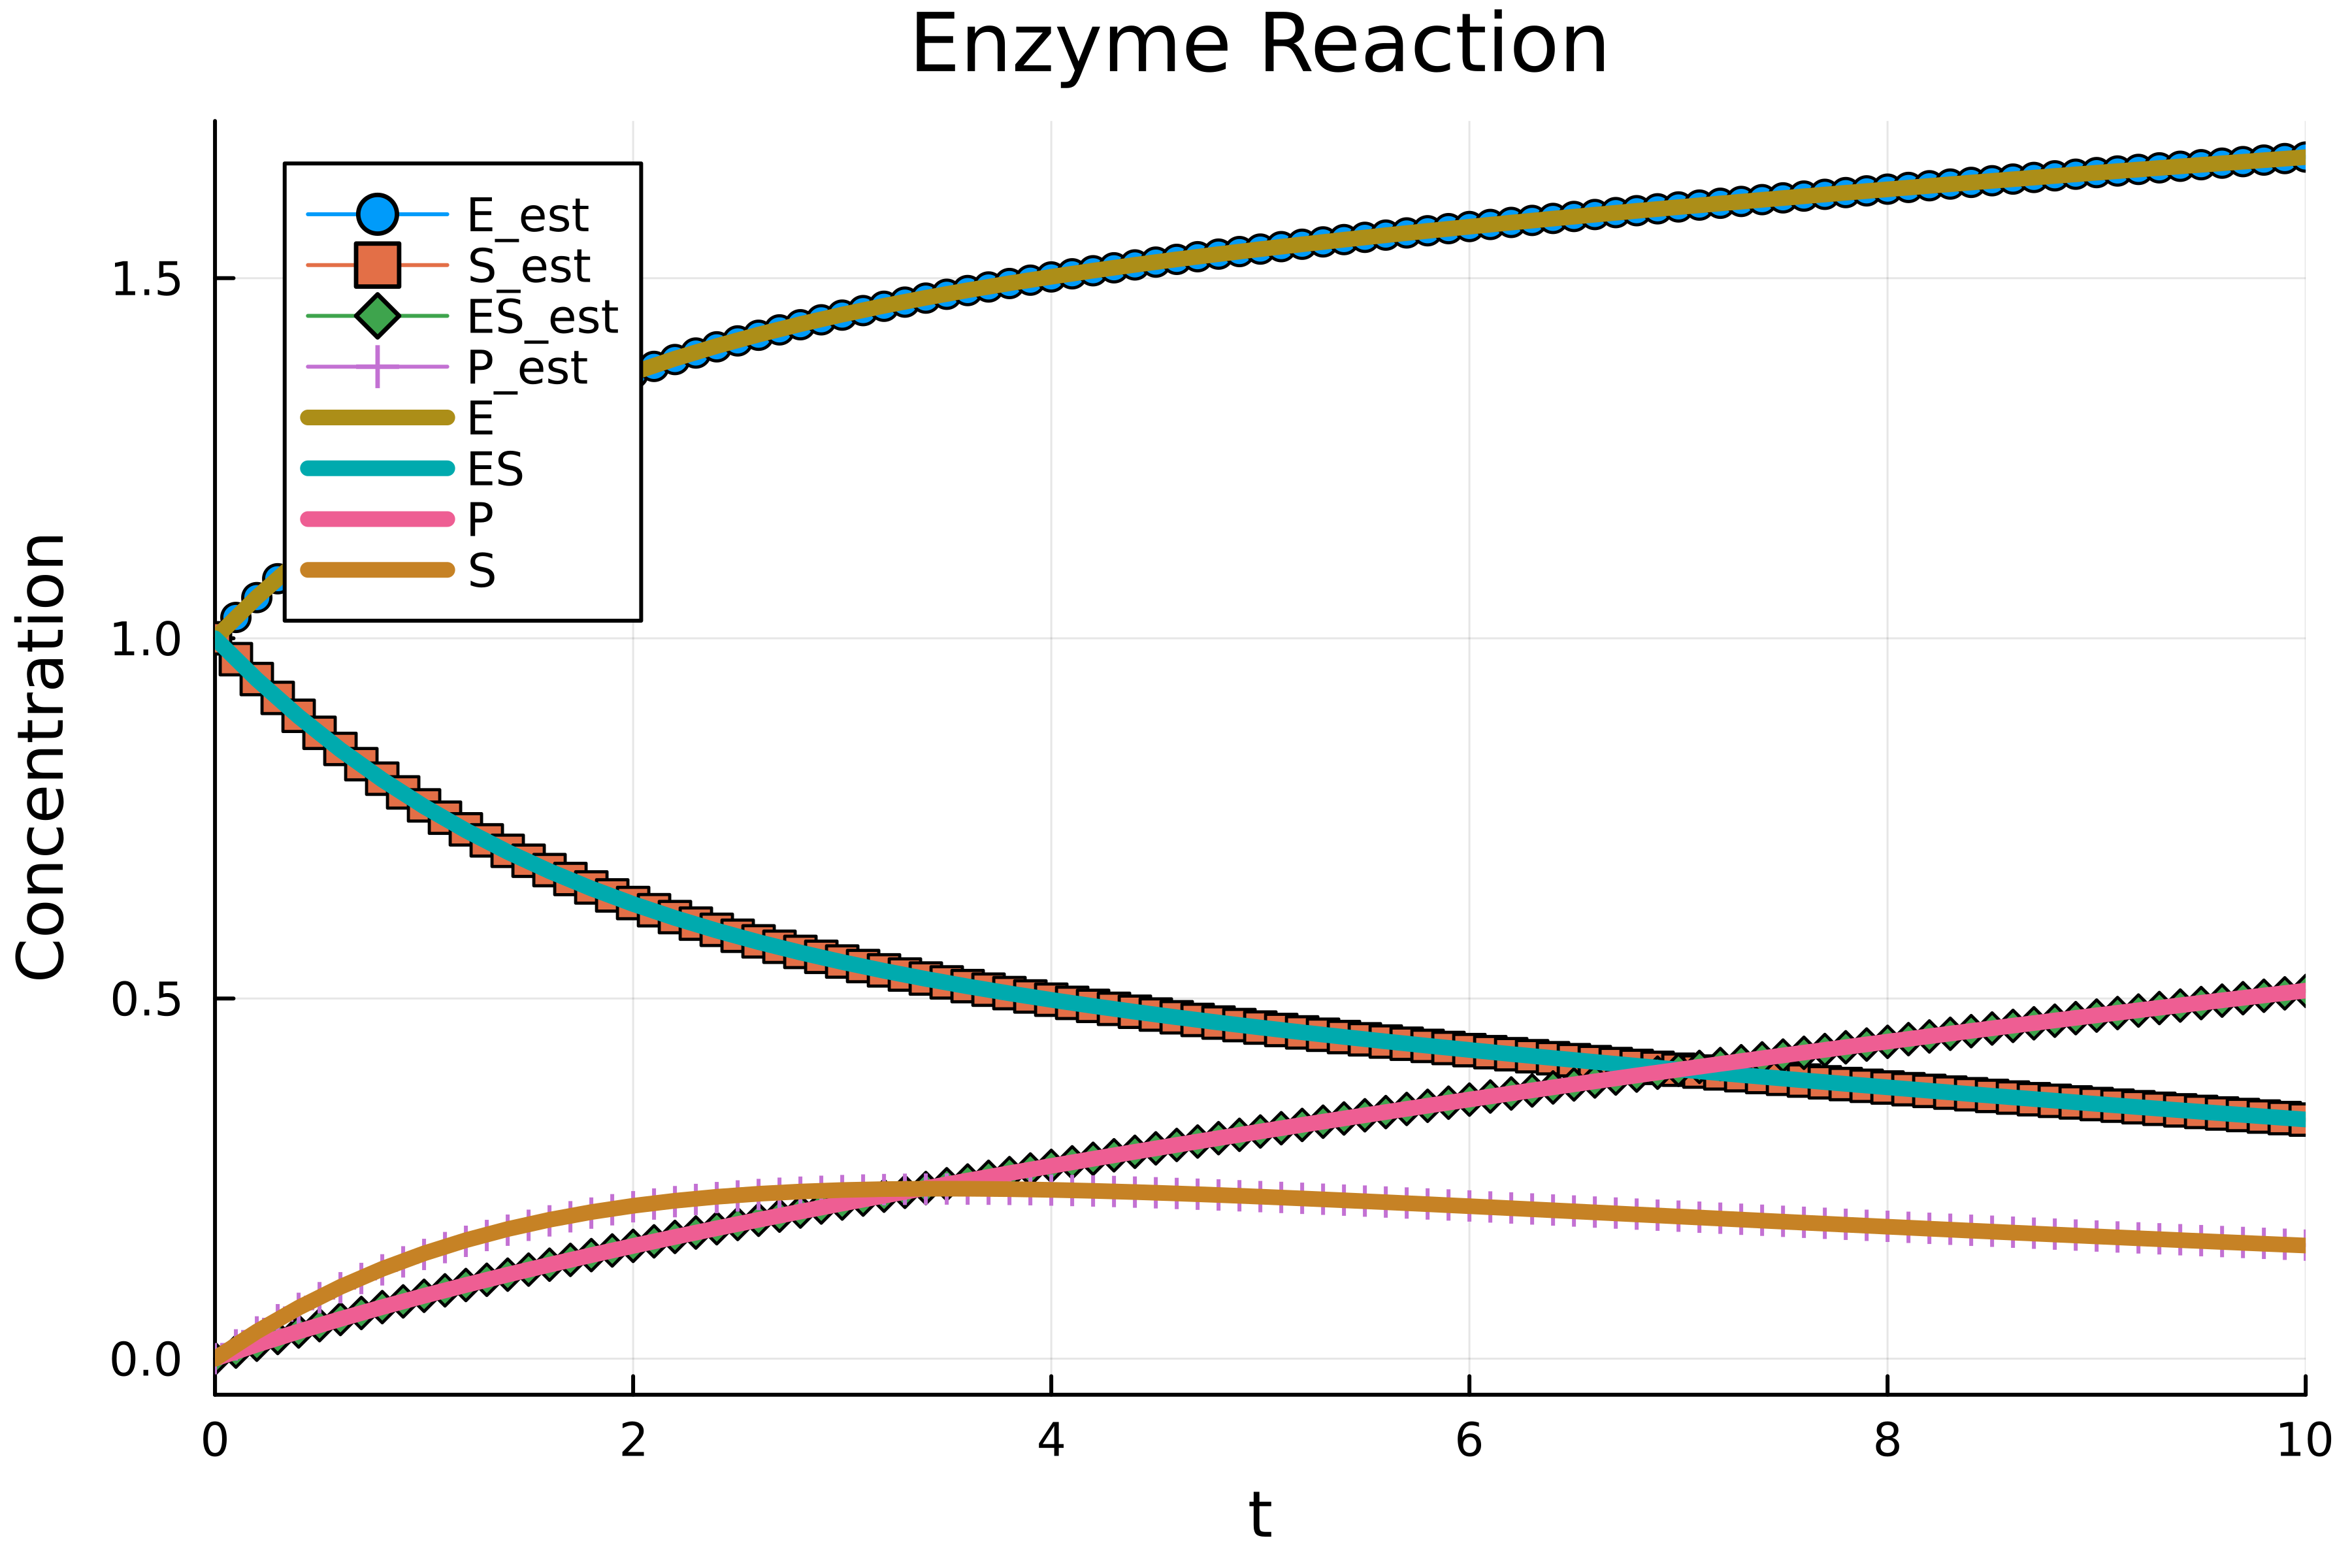

In [37]:
# Plot the results
using Plots
markers = hcat([:circle, :square, :diamond, :cross]...)
sol_est = solve(ODEProblem(sys, u₀, tspan, paramsest), Tsit5(), saveat=0.1)
p1 = plot(sol_est, label = ["E_est" "S_est" "ES_est" "P_est"], lw = 1, dpi = 600, 
    markers = markers, markersize = 4, xlabel = "Time", ylabel = "Concentration")
plot!(p1, sol, title = "Enzyme Reaction", lw = 4, dpi = 600)

# Save the figure
savefig("../plots/Enzyme_Reaction.png")
display(p1)

# Evaluating the results
The regression is run once again for different numbers of collocation points, and the results are compared to the original parameters. The goal is to see how the number of collocation points affects the accuracy of the recovery. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves. 


In [38]:
using Random
Random.seed!(1234) # Set seed for reproducibility
include("../utils/julia_utils.jl")
export create_table, noise_v_collocation_points

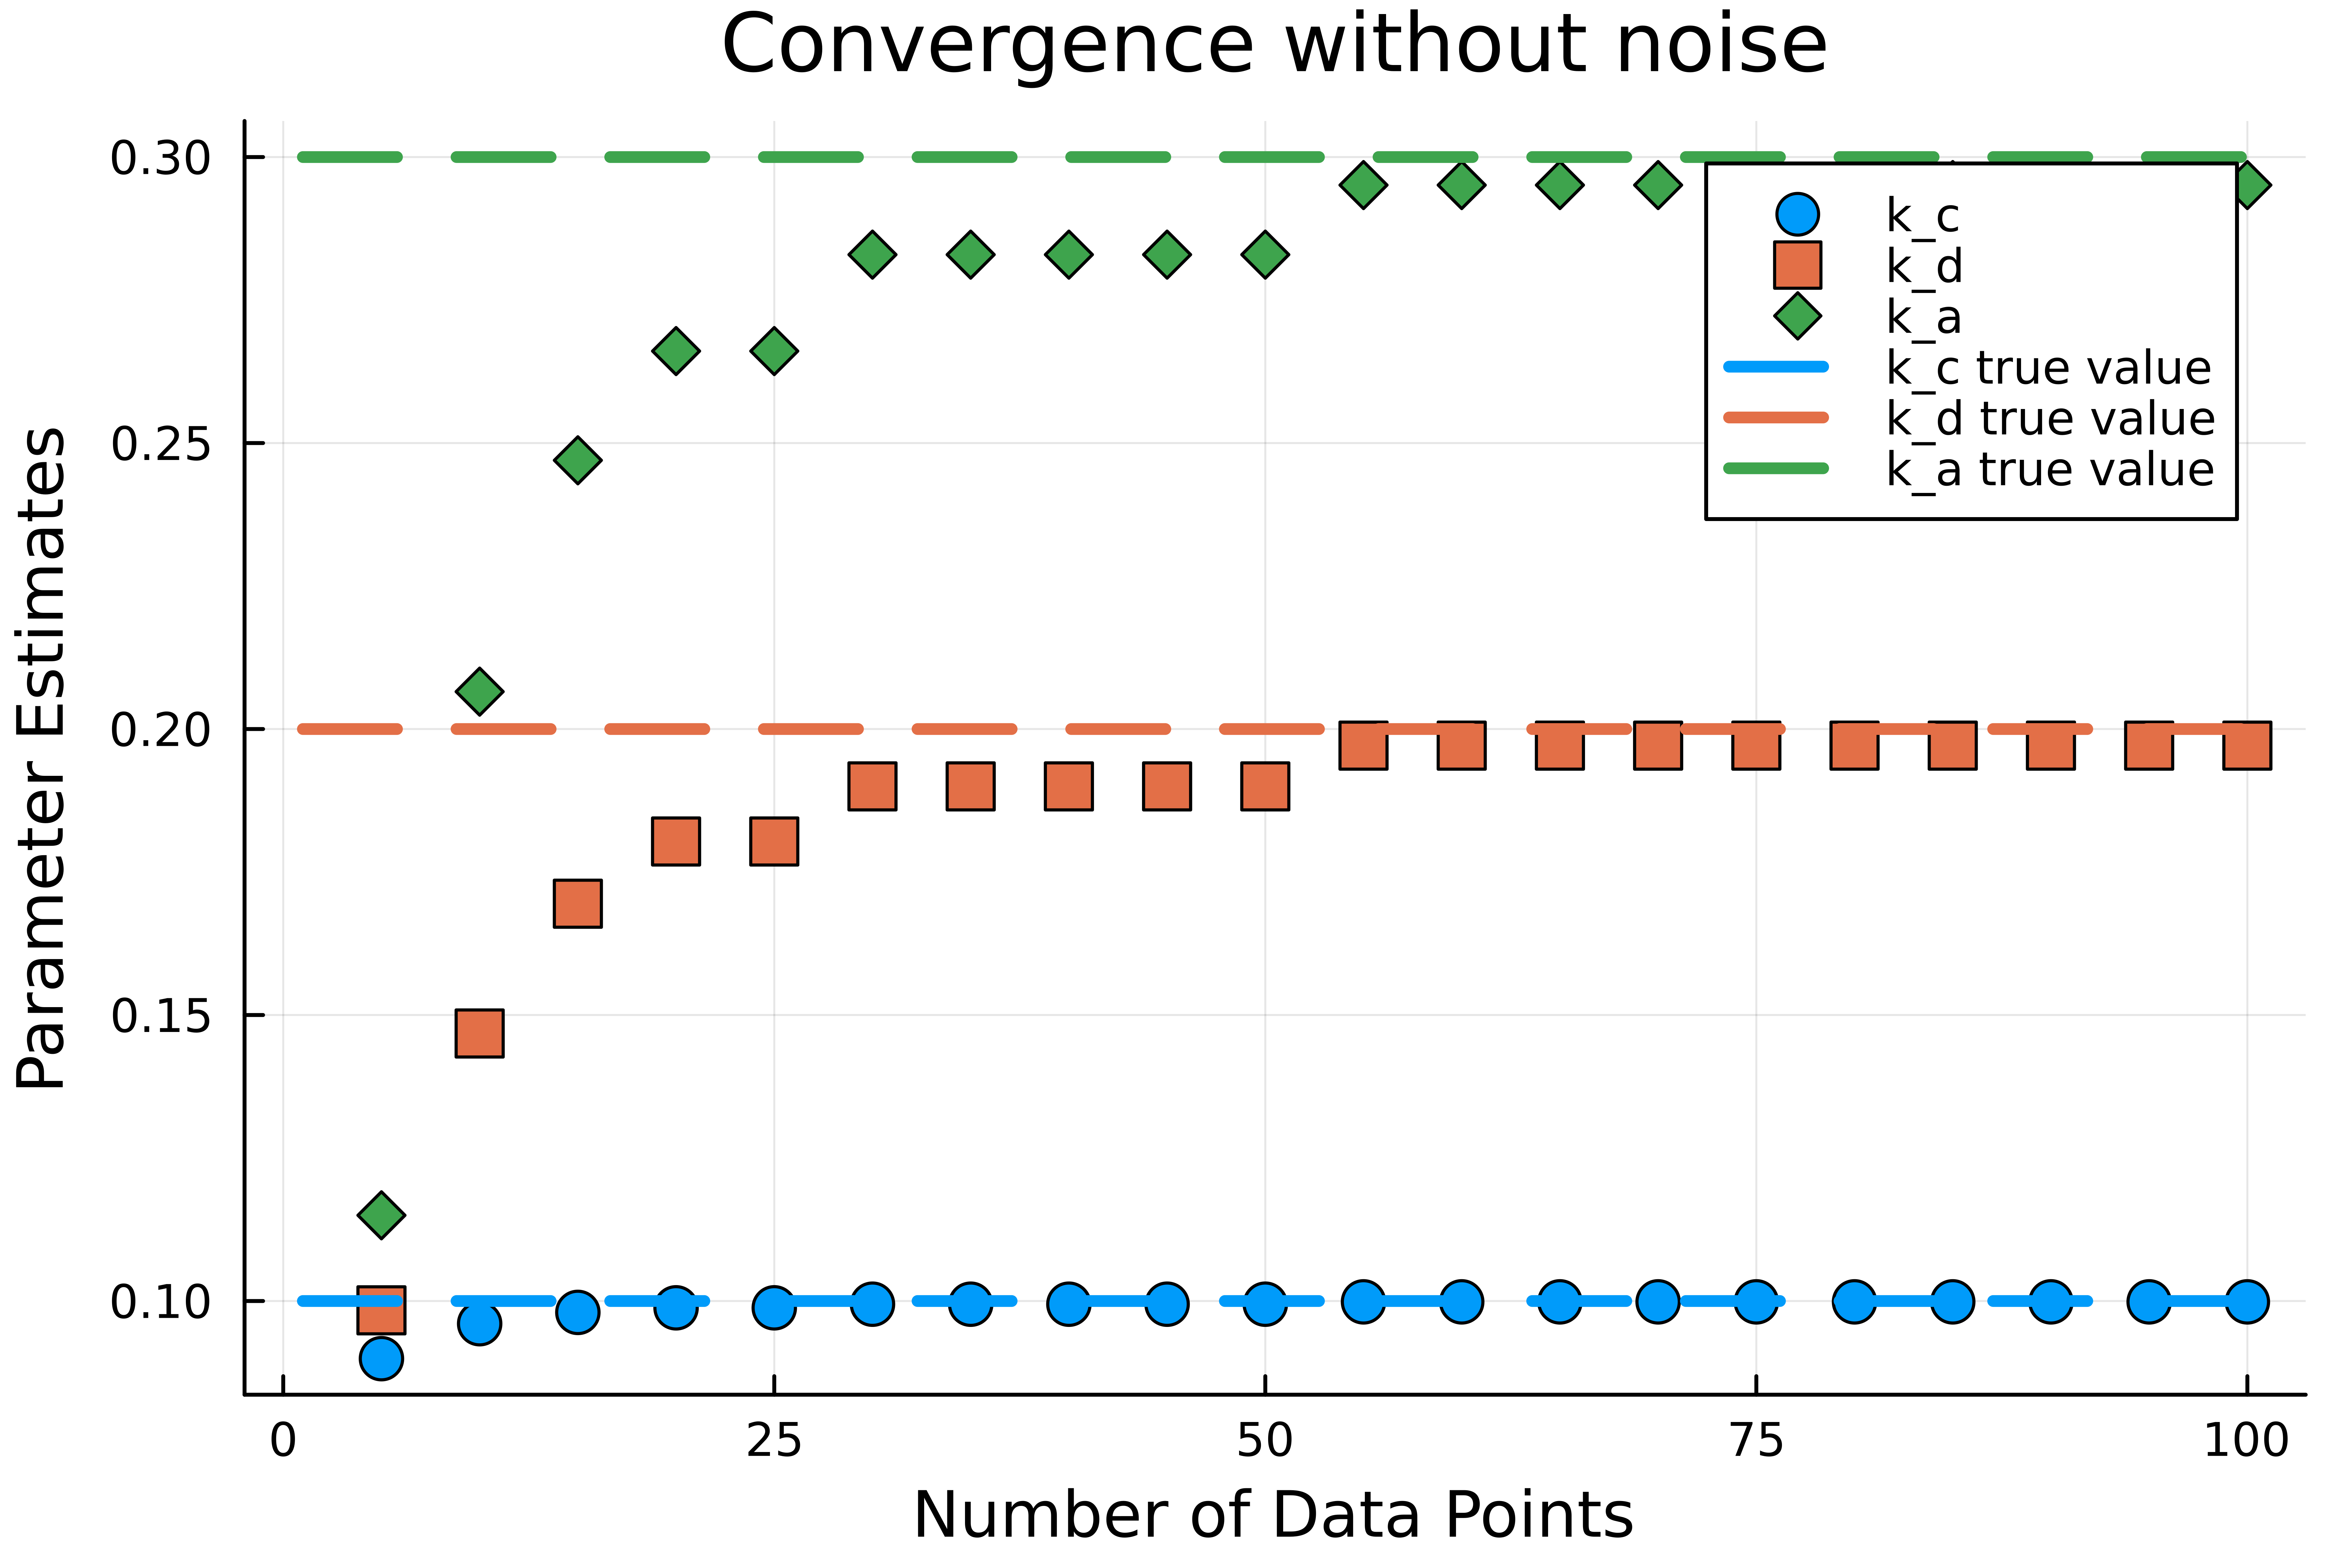

In [39]:
noise_vals = [0.0]
n_data_points = collect(5:5:100)
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

#parameter convergence without noise
marker_shapes = [:circle, :square, :diamond, :utriangle]
p1 = plot()
parameter_names = [string(param) for param in parameters(sys)]
x_values = collect(first.(keys(parameter_estimates)))
parameter_values = hcat([collect(values(parameter_estimates[n_data_points, 0.0])) for n_data_points in x_values]...)
scatter!(p1, x_values, parameter_values', label = hcat(parameter_names...), xlabel = "Number of Data Points", ylabel = "Parameter Estimates",
     title = "Convergence without noise", lw = 2, dpi = 1200, markershape = hcat(marker_shapes...), markersize = 6, legend = :topright)
#plot horizontal lines for true parameter values
for (i, param) in enumerate(parameters(sys))
    plot!(p1, [1, maximum(n_data_points)], repeat([p[param]], 2), label = "$(param) true value", ls = :dash, lw = 3, color = i)
end
savefig("../plots/Enzyme_convergence_no_noise.png")
display(p1)

The convergence of the parameters is evaluated once again, but for different numbers of collocation points and noise levels. The results are expected to show that as the number of collocation points increases, the accuracy of the recovery improves, and the noise level has a significant impact on the accuracy of the recovery.

In [40]:
#
noise_vals = [0.0, 0.01, 0.05, 0.1]
n_data_points = [10, 50, 100, 200]
n_iter = 20
parameter_estimates = noise_v_collocation_points(sys, sol, noise_vals, n_data_points; n_iter)

rel_error_ests = copy(parameter_estimates)
#calculate relative errors
for ((n_data_points, noise_val), estimates) in parameter_estimates
    rel_error_ests[(n_data_points, noise_val)] = abs.(estimates .- values(p)) ./ abs.(values(p))
end

### $k_a$ relative errors

In [41]:
using DataFrames
ka_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 1)


Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,3.966,3.394,7.774,1.443
2,50,0.5556,0.2478,3.101,8.894
3,100,0.1476,0.362,2.815,1.895
4,200,0.1476,0.5936,0.161,8.352


### $k_d$ relative errors

In [42]:
kd_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 2)

Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,26.61,26.36,28.2,18.06
2,50,5.014,4.427,1.412,15.11
3,100,1.45,1.132,1.091,2.227
4,200,1.45,1.937,2.931,14.06


### $k_c$ relative errors

In [43]:
kc_rel_errors_percentage = create_table(rel_error_ests; parameter_idx = 3)

Row,n_data_points,noise_0.0,noise_0.01,noise_0.05,noise_0.1
,Int64,Float64,Float64,Float64,Float64
1,10,31.15,30.9,33.2,21.52
2,50,5.687,4.958,2.301,20.35
3,100,1.633,1.199,1.381,4.2
4,200,1.633,2.265,3.868,15.68
